In this notebook, I will attempt to better understand some pretrained networks by generating an input image on which the network classifies the input most confidently to some target class.

# Setup

In [0]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

We're on colab so we should be able to use a GPU. The following line sets the device appropriately and allows you to confirm that the device is GPU. 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Pytorch's pretrained networks can be easily loaded with torchvision.models. They are all trained on ImageNet. 

Let's load a model! We need to set the model to eval so that its weights are unaltered as we train the input image.



In [4]:
resnet101 = models.resnet101(pretrained=True).to(device).eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


The networks trained on ImageNet expect inputs to match a specific distribution, so we will need to add a normalization layer at the very beginning.

In [0]:
mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(-1, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(-1, 1, 1)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = mean#torch.tensor(mean).view(-1, 1, 1)
        self.std = std#torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [0]:
def norm_cnn(model):
  cnn = copy.deepcopy(model)
  normalization = Normalization(mean, std).to(device)
  out = nn.Sequential(normalization)
  out.add_module('cnn', cnn)
  return out


Some code for viewing images.

In [0]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=''):
    norm = (tensor-mean) / std
    image, norm = [unloader(x.cpu().clone().squeeze(0)) for x in [tensor, norm]]
    plt.subplot(121)
    plt.imshow(image)
    plt.title(title)
    plt.subplot(122)
    plt.imshow(norm)
    plt.title('Normalized')
    plt.pause(0.001) # pause a bit so that plots are updated

Let's make an input image. Some choices are random noise or a uniform color (white, black, gray). 

In [0]:
imsize = 224

def get_input_img(noise=False):
    if noise:
      img = torch.randn([1, 3, imsize, imsize], device=device)
    else:
      img = torch.ones([1, 3, imsize, imsize], device=device)

    return img

_=get_input_img()

We also need to set our target. The class labels for ImageNet can be found [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). We can do this in one line which will go in our training function.

In [0]:
target = torch.LongTensor([440]).to(device)

Now we're going to make our own model, whose trainable parameters are just the pixels of the image we seek to generate.

In [0]:
def trainInputToTarget(target_ind, noise=False, title=None, input_img=None, \
                       display=True, model=resnet101):
    target = torch.LongTensor([target_ind]).to(device)

    if input_img is None:
      input_img = get_input_img(noise)
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.Adam([input_img.requires_grad_()], lr=0.1)
    criterion = nn.CrossEntropyLoss()
    cnn = norm_cnn(model)
    iteration = [0]
    max_num_steps = 1000
    prob = [0]
    while prob[0] < 0.999 and iteration[0] <= max_num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            out = cnn(input_img)
            loss = criterion(out, target.detach())
            loss.backward()

            # let's figure out what probability our network thinks the current image
            # belongs to the target class
            probs = F.softmax(out, dim=1)
            prob[0] = probs[0][target_ind]

            if display and (iteration[0] % 10 == 0 or iteration[0] < 10 or prob[0] > 0.999):
                print("iteration: {}.......P(in target class): {:.6f}.......Loss: {:.6f}" \
                      .format(iteration[0], prob[0], loss.item()))
                imshow(input_img, title)
                print()
            iteration[0] += 1
          
            return loss

        optimizer.step(closure)

    return input_img

# Experiments

Now we're ready to experiment. The human name of the target class is labelled as a comment in each call to trainInputToTarget. 

## Pugs

In [42]:
# 254 - pugs
pug_noise = trainInputToTarget(254, noise=True, title='pug')

Output hidden; open in https://colab.research.google.com to view.

In [43]:
# 254 - pugs, not from noise now
pug = trainInputToTarget(254, title='pug')

Output hidden; open in https://colab.research.google.com to view.

## Spider Web

In [44]:
# 815 - spider's web
spider_web_noise = trainInputToTarget(815, noise=True, title='spider web')
spider_web = trainInputToTarget(815, title='spider web')

Output hidden; open in https://colab.research.google.com to view.

## Triumphal Arch

In [45]:
# 873 - triumphal arch
arch_noise = trainInputToTarget(873, noise = True, title='triumphal arch')
arch = trainInputToTarget(873, title='triumphal arch')

Output hidden; open in https://colab.research.google.com to view.

## Bow Tie

In [46]:
# 457 - bow tie
bow_tie_noise = trainInputToTarget(457, noise=True, title='bow tie')
bow_tie = trainInputToTarget(457, title='bow tie')

Output hidden; open in https://colab.research.google.com to view.

## Soccer Ball

iteration: 0.......P(in target class): 0.000993.......Loss: 6.915180


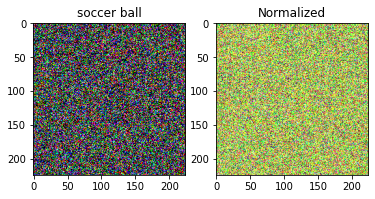


iteration: 1.......P(in target class): 0.027770.......Loss: 3.583807


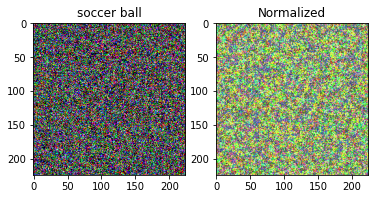


iteration: 2.......P(in target class): 0.607767.......Loss: 0.497963


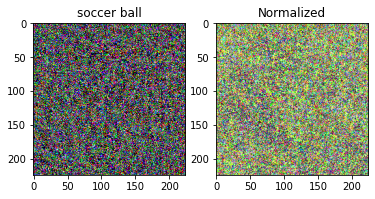


iteration: 3.......P(in target class): 0.999930.......Loss: 0.000069


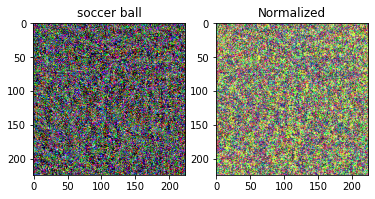


iteration: 0.......P(in target class): 0.000486.......Loss: 7.629007


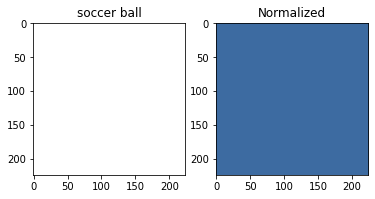


iteration: 1.......P(in target class): 0.000418.......Loss: 7.780248


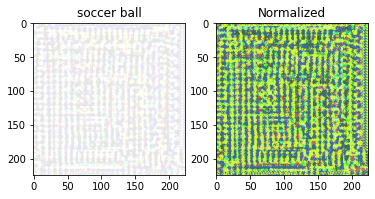


iteration: 2.......P(in target class): 0.002410.......Loss: 6.028091


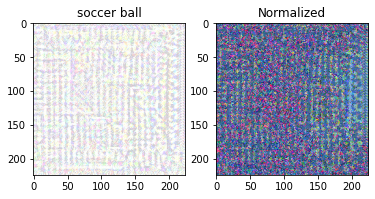


iteration: 3.......P(in target class): 0.486916.......Loss: 0.719663


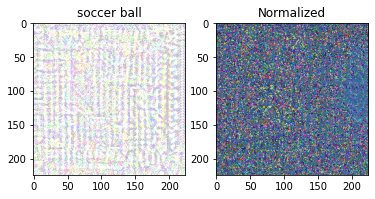


iteration: 4.......P(in target class): 0.999997.......Loss: 0.000002


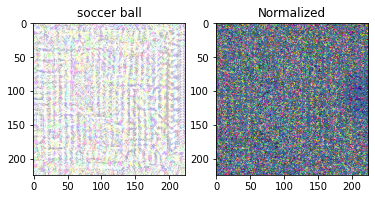

In [47]:
# 805 - soccer ball
soccer_ball_noise = trainInputToTarget(805, noise=True, title='soccer ball')
soccer_ball = trainInputToTarget(805, title='soccer ball')

## School Bus

In [48]:
# 779 - school bus
school_bus_noise = trainInputToTarget(779, noise=True, title='school bus')
school_bus = trainInputToTarget(779, title='school bus')

Output hidden; open in https://colab.research.google.com to view.

# Discussion

After a number of experiments, we see that the generated images are (to a human) nonsense. Here are some takeaways:


*   The generated images look very noisy, but they still have some structure. The structures just seem to be unfamiliar to humans, and in my opinion, structures seem to be local in scope (i.e. no large shapes, just small lines and dashes).
*   In less than ten iterations, we can turn an image of nothing into something that the network classifies as our target with a probability of over 99%. This in a sense highlights a shortcoming of deep networks in that they can be fooled with perturbations that (to a human) may seem like nothing more than random noise. Not just fooled, completely embarassed!
*   The first few iterations are very interesting to me, as the gradient often has a lot of symmetry to it. In particular, it seems like a grid is introduced to the blank image, from which more complicated lines can be drawn (diagonals, and eventually curves). One explanation is that local patches in a blank image are identical, so maybe its not too surprising that the gradient is similar for eatch patch. This pattern holds for many different target classes -- it seems like the first step is largely always the same.
*   One hypothesis is that this method of generation will perform worse for heterogenous target classes. This could hold true, but it's hard to say that the method does any better for (what I think would be) more homogenous classes (e.g. ipod, soccer ball). A follow up experiment could be to try a classifier with simpler classes  (maybe MNIST digits) and see if this generation still creates nonsensical images. My hypothesis is that this generation may still very well fail, because classifiers can only be expected to do well on data it has seen, but the data it sees is only a very small subset of the entire image space (for a 256x256 color image, we have 3^(2^16) possible images), and in fact even the set of images that we consider to be 'realistic' may be a tiny subset of the total image space. 






# Part Two - starting off on a better foot

Executive summary of findings:



*   Backprop changes the input image to noise, even when we start with an input that should be close to the target class.
*   Image space is too big and decision boundaries are not smooth. The subset of real images in the entire image space is swiss-cheese like, so moving directly in the image space likely leads to wandering into the garbage subset of the image space. 
*   Networks should be able to recognize garbage, but traditionally we don't train for that, because our evaluation metrics were completely unaffected by how the network behaves on inputs that are outside the distribution of the training data. If we want networks to work on anything (which they must do in the real world), they definitely should have a mechanism to handle this failure mode. At the least, classifiers should have a class for 'unrecognized' or 'garbage' inputs. 


## More Setup - meet my pup Rainier!
__________________
OK! Here's another idea, what happens when we start with something real? Will this help the network make more realistic changes? For example, can we make a dog doggier, instead trying to get a dog from scratch with only backprop? Or even, could we take an image of a cat and morph it into a dog?

My hypothesis: definitely not with this mechanism haha. I think the changes will again seem nonsensical to us, and may even be imperciptible. That still would be pretty cool, as it shows how devious data poisoning could be. If that's the case, a future experiment would be to see if a poison obtain from one network is also lethal on another. 

Some code for loading actual images. 

In [0]:
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.CenterCrop(imsize), # crop to make square
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [20]:
def rainier():
  rainier = image_loader('/content/rainier.jpg')
  return rainier

cnn = norm_cnn(resnet101)
out = cnn(rainier())
_, pred = torch.max(out, 1)
print(F.softmax(out, dim=1)[0][pred])
print(pred)

tensor([0.5986], device='cuda:0', grad_fn=<IndexBackward>)
tensor([266], device='cuda:0')


Incredible! ResNet says my dog is a miniature poodle. Rainier is actually miniature golden doodle, but I'd say miniature poodle is spot on, especially since there isn't a class for golden doodles. Also note that the probability of being in that class is no where near as high as the probabilities I have been training the inputs to -- maybe my high threshold is part of the problem?

## Experiments

In [21]:
# 254 - pugs
_ = trainInputToTarget(target_ind=254, input_img=rainier(), title='Rainier to Pug')

Output hidden; open in https://colab.research.google.com to view.

What have they done to my beautiful dog! I am distressed and offended. Interesting that the dog like features were not kept!

In [22]:
# 206 - curly coat retriever, a closer relative
_ = trainInputToTarget(target_ind=206, input_img=rainier(), title='Rainier to Curly-coat Retriever')

Output hidden; open in https://colab.research.google.com to view.

In [23]:
# 266 - mini poodle, what rainier was originally classified as
_ = trainInputToTarget(target_ind=266, input_img=rainier(), title='Poodle-iest Rainier')

Output hidden; open in https://colab.research.google.com to view.

## Discussion




The backprop method again makes perturbations that lack human meaning, even when the transformation to be made is less dramatic than starting from scratch. I won't even try the other ideas I had, like going from a cat to a dog with this method, because interestingly the classifier does not retain features that would still be useful. 

This is very curious because our intuition is that classifiers learn how to recognize features pertinent to different classes. Certainly, backprop is nowhere near as sophisticated as other generative methods like GANs or VAEs, but the fact that backprop causes an obscuration and eventual removal of features that should still belong to the target class raises questions about what our gradient descent is doing and why. 

Gradient descent is supposed to change parameters to optimize some objective function. In this case, our objective function tells us how strongly an image is classified to a target class. The changes backprop makes are in theory the most efficient/direct alterations needed to optimize this objective. Yet, these changes do not follow human intuition, and actually completely ruin our input. 

My conclusion once again comes back to the fact that we are optimizing in the entire image space. In this space, there aren't smooth decision boundaries nor are there well-clustered/contiguous regions pertaining to different classes. In fact, if we just consider the subset of real images (i.e. things that exist in reality and are not noise/nonsense), it is probably swiss-cheese like. Thus, the most direct path to move from one class to another probably causes our beautiful picture of Rainier to wander out of the subset of real images and into nonsense.

The problem is that the nonsense is still very strongly classified as something real. On one hand, we shouldn't be too surprised, as the age old computer science principle tells us: garbage in, garbage out. The network we use was trained on real images, so its behavior on nonsensical images can not be predicted/depended on. Also, the network doesn't even have an option to say the input is garbage -- it will classify to one of the classes no matter what. 

Nonetheless, I think this is a shortcoming worth addressing. A simple fix is to train with nonsensical images along with real images, and importantly, to have an additional final node corresponding to a garbage class. Some of the images in our garbage class can be just random noise or arbitrary inputs like what we were using at the top of this notebook. But to fix the problem we've highlighted in this notebook, we should definitely train with images that we know can embarass the network. That is, we would generate adversarial examples based on our network and correct the network by training against them. 

One challenge I foresee is balancing our classes. There is a lot more garbage than there is real images, so I'd worry about our network favoring garbage. I think any kind of adversarial training would probably hurt validation accuracy as it is traditionally considered, but some measure capturing the networks ability to recognize and not fail on garbage would improve (is this robustness?).

One other curious occurence is that when we just try to enhance an image (alter it so that the network matches it to its own class with higher probability), the loss goes up in the first two iterations! The image is mostly degraded before reemerging out of the noise. I have no explanation for this. Maybe in moving closer to the center of the class, the image gets dragged into lots of noise? This again builds on the idea that the classes do not form contiguous subsets of the image space. 

#Part Three - one poison fits all?

## Setup and Motivation

I'm often curious about whether or not data poisoning is a real problem if it requires knowledge of and access to the network. There very well may be more sophisticated poisoning methods that don't require direct access to the network (I'm not very well read re: adversarial deep learning), but could it be the case that an adversarial example generated from one network could fool a different network? 

We can put this to the test! The experiment we are setting up here is giving all the leverage to the poisoners, since the networks that we'll try to poison were all trained on the same dataset (ImageNet). 

In [92]:
vgg19 = models.vgg19_bn(pretrained=True).to(device).eval()
vgg16 = models.vgg16_bn(pretrained=True).to(device).eval()
alexnet = models.alexnet(pretrained=True).to(device).eval()
squeezenet = models.squeezenet1_0(pretrained=True).to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [0]:
def classify(model, img, model_name):
  cnn = norm_cnn(model)
  out = cnn(img)
  _, pred = torch.max(out, 1)
  print('{:<15s} {:<15d} {:<15f}'.format(model_name,pred.item(),F.softmax(out, dim=1)[0][pred].item()))

def display_model_predictions(imgs, models):
  for img_key in imgs.keys():
    print('_'*60)
    print('Target class: {}'.format(img_key))
    print('{:<15s} {:<15s} {:<15s}'.format('Model','Pred. Class','Probability'))
    for model_name in models.keys():
      classify(models[model_name], imgs[img_key], model_name)

## Experiment 1: Images Generated from Uniform Input


In [94]:
imgs = {254:pug, 815:spider_web, 873:arch, 805:soccer_ball, 457:bow_tie, 779:school_bus}
models = {'vgg19':vgg19, 'vgg16':vgg16, 'alexnet':alexnet, 'squeezenet':squeezenet}

display_model_predictions(imgs, models)

____________________________________________________________
Target class: 254
Model           Pred. Class     Probability    
vgg19           562             0.198330       
vgg16           904             0.151148       
alexnet         533             0.817627       
squeezenet      611             0.340866       
____________________________________________________________
Target class: 815
Model           Pred. Class     Probability    
vgg19           111             0.025302       
vgg16           904             0.119468       
alexnet         824             0.216229       
squeezenet      533             0.115992       
____________________________________________________________
Target class: 873
Model           Pred. Class     Probability    
vgg19           904             0.107521       
vgg16           580             0.200530       
alexnet         533             0.361952       
squeezenet      611             0.166524       
___________________________________________

## Experiment 2: Images Generated from Random Noise


In [95]:
imgs_from_noise = {254:pug_noise, 815:spider_web_noise, 873:arch_noise, \
        805:soccer_ball_noise, 457:bow_tie_noise, 779:school_bus_noise}
display_model_predictions(imgs_from_noise, models)

____________________________________________________________
Target class: 254
Model           Pred. Class     Probability    
vgg19           818             0.034796       
vgg16           904             0.442520       
alexnet         735             0.205570       
squeezenet      703             0.238105       
____________________________________________________________
Target class: 815
Model           Pred. Class     Probability    
vgg19           904             0.124220       
vgg16           904             0.560380       
alexnet         735             0.244487       
squeezenet      703             0.191946       
____________________________________________________________
Target class: 873
Model           Pred. Class     Probability    
vgg19           904             0.067067       
vgg16           904             0.662634       
alexnet         735             0.195308       
squeezenet      703             0.176687       
___________________________________________

Looks like the generated images are not predicted to have the target labels when other networks are used. In fact, the other networks don't really know what to make of these generated inputs, as most have low maximum probabilities. 

Here are the labels for some of the more common predictions:


*   533 - dish cloth (alexnet seems to choose this often)
*   611 - jigsaw puzzle
*   904 - window screen (vgg seems to choose this often)
*   735 - poncho






## Experiment 3 -- vgg19 poison for vgg16

Seemed like vgg19 and vgg16 had some similar predictions for the images generated from noise. Makes sense given that they have very similar architectures. Let's see if images generated based on backpropogation from one vgg can fool the other vgg!

In [0]:
from tqdm.notebook import tqdm

def generate_examples(model):
  out = {}
  for ind in tqdm(imgs_from_noise.keys()):
    out[ind] = trainInputToTarget(ind, noise=True, display=False, model=model)
  return out

In [107]:
vgg16_examples = generate_examples(vgg16)

In [108]:
vgg19_examples = generate_examples(vgg19)

In [109]:
display_model_predictions(vgg16_examples, {'vgg19':vgg19})

____________________________________________________________
Target class: 254
Model           Pred. Class     Probability    
vgg19           111             0.067848       
____________________________________________________________
Target class: 815
Model           Pred. Class     Probability    
vgg19           111             0.035992       
____________________________________________________________
Target class: 873
Model           Pred. Class     Probability    
vgg19           904             0.077015       
____________________________________________________________
Target class: 805
Model           Pred. Class     Probability    
vgg19           644             0.038836       
____________________________________________________________
Target class: 457
Model           Pred. Class     Probability    
vgg19           904             0.043371       
____________________________________________________________
Target class: 779
Model           Pred. Class     Probability   

In [110]:
display_model_predictions(vgg19_examples, {'vgg16':vgg16})

____________________________________________________________
Target class: 254
Model           Pred. Class     Probability    
vgg16           904             0.466354       
____________________________________________________________
Target class: 815
Model           Pred. Class     Probability    
vgg16           904             0.522845       
____________________________________________________________
Target class: 873
Model           Pred. Class     Probability    
vgg16           904             0.468252       
____________________________________________________________
Target class: 805
Model           Pred. Class     Probability    
vgg16           904             0.404299       
____________________________________________________________
Target class: 457
Model           Pred. Class     Probability    
vgg16           904             0.416352       
____________________________________________________________
Target class: 779
Model           Pred. Class     Probability   